In [1]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.data import Dataset, DataLoader
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import u_net
from monai import inferers

In [2]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

In [3]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

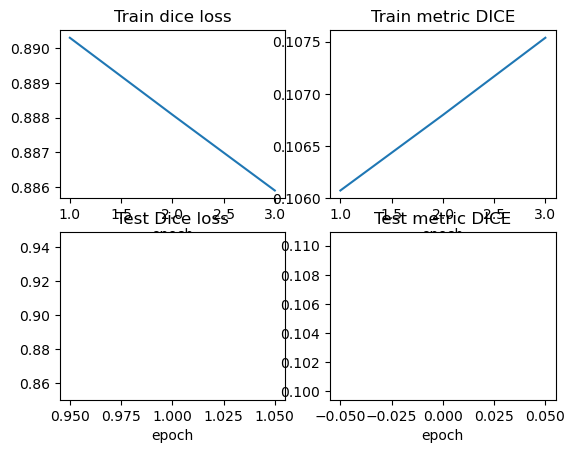

In [5]:
plt.figure(f'Results of {datetime.now().strftime("%d %B")}')
plt.subplot(2, 2, 1)
plt.title('Train dice loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title('Train metric DICE')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title('Test Dice loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title('Test metric DICE')
x = [i for i in range(len(test_metric))]
y = test_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.show()

In [6]:
path_train_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_volumes').glob('*'))
path_train_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_segmentations').glob('*'))

path_test_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_volumes').glob('*'))
path_test_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_segmentations').glob('*'))

train_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentations)]
test_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip (path_test_volumes, path_test_segmentations)]

In [7]:
test_transform = Compose([
    LoadImaged(keys = ('vol', 'seg')),
    EnsureChannelFirstd(keys=["vol", "seg"]),
    Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
    CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
    Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
    ToTensord(keys=["vol", "seg"])
])

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [8]:
num_workers = os.cpu_count()

test_ds = Dataset(data = test_files,
                  transform = test_transform)
test_dataloader = DataLoader(dataset = test_ds,
                             num_workers = num_workers,
                             batch_size = 1)

In [ ]:
model, device = u_net.unet()
model.load_state_dict(torch.load(target_dir / 'ModelV1.pth'))
model.eval()

In [ ]:
test_patient = next(iter(test_dataloader))

In [53]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    #test_patient = next(iter(test_dataloader))
    t_volume = test_patient['vol']
    test_outputs = inferers.sliding_window_inference(inputs = t_volume.to(device),
                                                     roi_size = roi_size,
                                                     sw_batch_size = sw_batch_size,
                                                     predictor = model
                                                     )
    prediction = torch.softmax(test_outputs, dim = 1).argmax(dim = 1)
    #sigmoid_activation = Activations(sigmoid = True)

    

In [54]:
#prediction = prediction.unsqueeze(dim = 0)
prediction.shape, test_outputs.shape, test_patient['seg'].shape


(torch.Size([1, 1, 128, 128, 64]),
 torch.Size([1, 8, 128, 128, 64]),
 torch.Size([1, 1, 128, 128, 64]))

In [ ]:
for i in range(5):
    plt.subplot(1, 3, 3)
    #prediction = prediction.squeeze()
    plt.imshow(prediction.detach().cpu()[0,0, :, :, i + 10])
    plt.show()

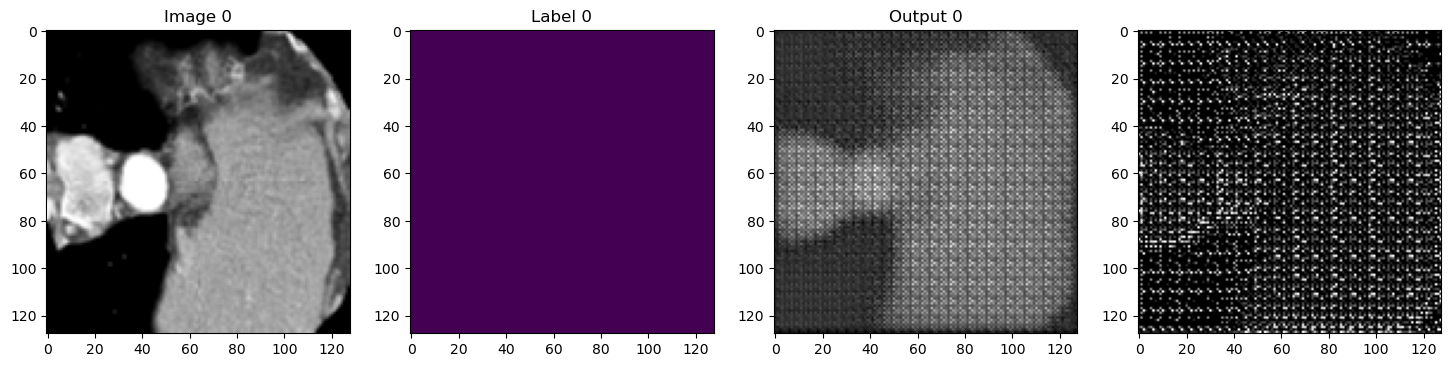

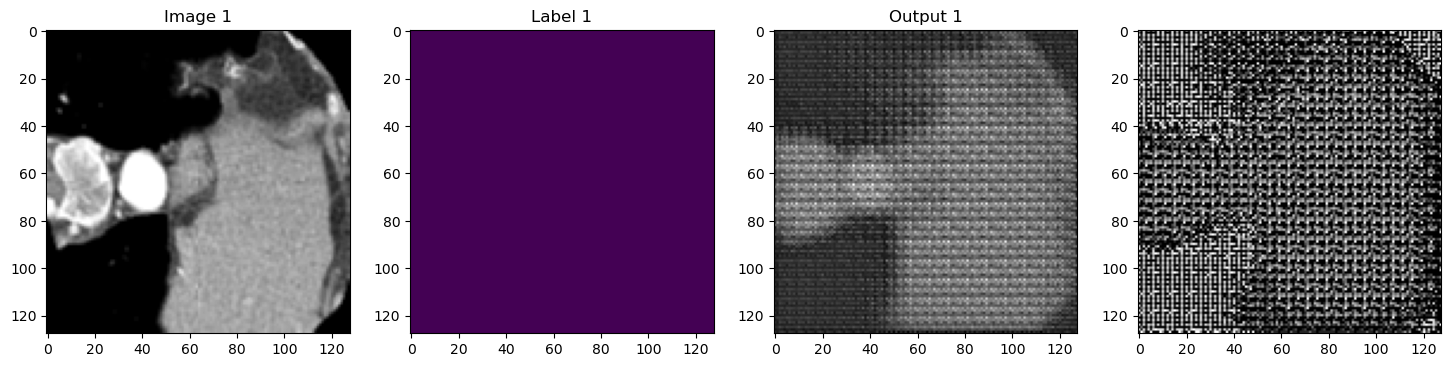

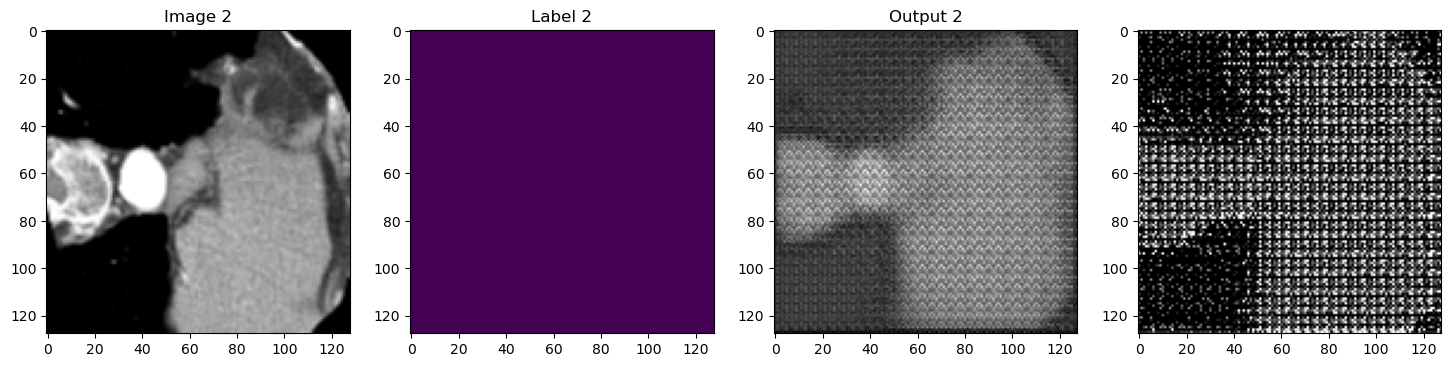

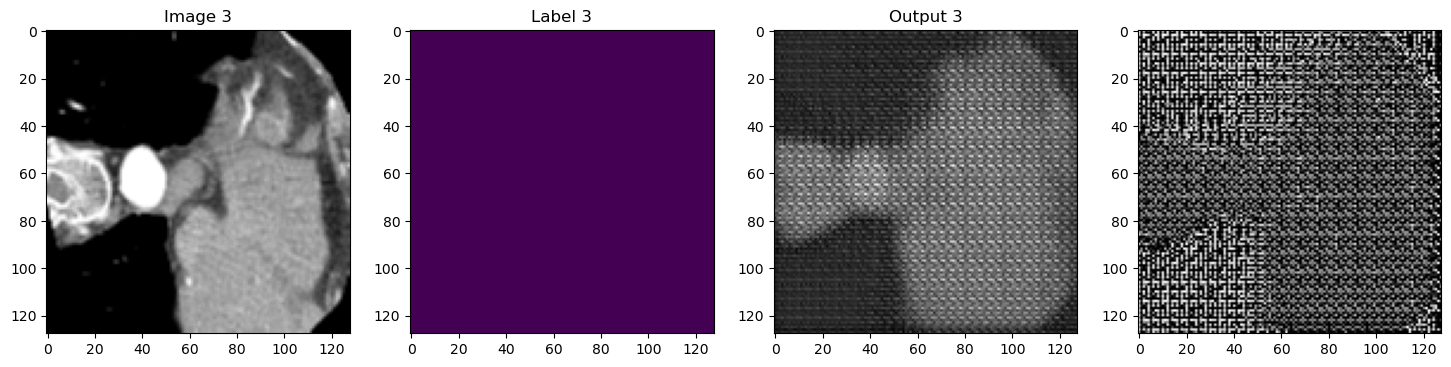

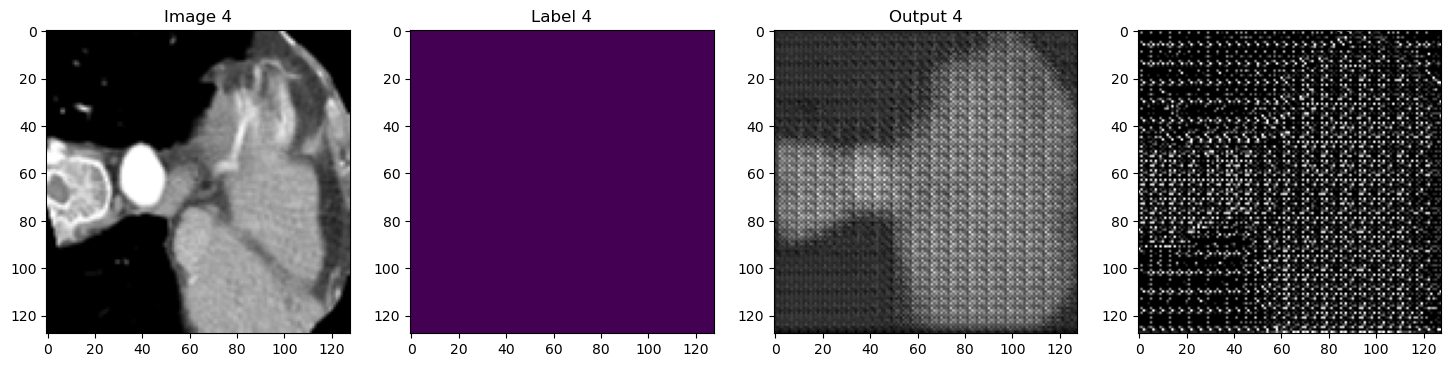

In [62]:
#test_outputs = sigmoid_activation(test_outputs)
# test_outputs = test_outputs > 0.53 Make the Values binary, i think not effective for our cause
for i in range(5):
        plt.figure('check', (18, 6))
        plt.subplot(1, 4, 1)
        plt.title(f'Image {i}')
        plt.imshow(test_patient['vol'][0, 0, :, :, i+10], cmap = 'gray')
        plt.subplot(1, 4, 2)
        plt.title(f'Label {i}')
        plt.imshow(test_patient['seg'][0, 0, :, :, i+10])
        plt.subplot(1, 4, 3)
        plt.title(f'Output {i}')
        plt.imshow(test_outputs.detach().cpu()[0, 0, :, :, i + 10], cmap = 'gray')
        
        plt.subplot(1, 4, 4)
        plt.imshow(prediction.detach().cpu()[0,0, :, :, i + 10], cmap = 'gray')
        plt.show()
        